# Week 3: Attention, Please!

Attention mechanisms,  are a cornerstone of modern natural language processing and form the heart of GPT (Generative Pre-trained Transformer) models. 

We are building on top of [the paper introducing Transformer architecture by Vaswani et al](https://arxiv.org/abs/1706.03762). 

#### What is Attention?
Attention in neural networks allows the model to focus on specific parts of the input when producing an output. In the context of language models like GPT, attention enables the model to consider relevant words or phrases when predicting the next word, regardless of their position in the sentence.

GPT models use a specific type of attention called "self-attention" within their transformer blocks. Attention fits into the GPT architecture through:

1. Input Embedding: Words are converted into vectors.
2. Positional Encoding: Position information is added to these vectors.
3. Transformer Blocks: Multiple layers, each containing:
    - Multi-Head Attention: Allows the model to attend to different aspects of the input simultaneously.
    - Feed-Forward Neural Network: Processes the attention output.
4. Output Layer: Produces probabilities for the next word.

In this notebook, we'll implement and visualize these attention mechanisms, providing you with a deep understanding of how GPT models process and generate text.

Let's begin our journey into the world of attention!

## 0. Query, Key, Value

In [2]:
# Import necessary libraries
import math
import base64
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display
from typing import Tuple, List

In [3]:
from helpers.check_todo import check_implementation
from helpers.show_mermaid import mm

In [4]:
# Create the src directory if it doesn't exist
import os
os.makedirs('src', exist_ok=True)

In [9]:
# TODO: Define your example sentence
sentence = "Think of humanity on the path towards more unfathomable complexity"

Let's use a simplfied representation of this sentence where each element is either "0" or "1"with 3 dimensions. We could think of these 3 dimensions as representing very basic linguistic features. For example:
1. First dimension could represent "action" or "concreteness"
2. Second dimension: Could represent "relation" or "abstractness"
3. Third dimension: Could represent "complexity" or "plurality".

Thus, a word "think" can be represented as [1, 0, 0] since it is an action verb, concrete, singular, while "of" as [0, 1, 0] since it is a relational word, abstract, singular. 

In [10]:
word_to_vec = {
    "Think": [1, 0, 0],
    "of": [0, 1, 0],
    "humanity": [1, 0, 1],
    "on": [0, 1, 1],
    "the": [1, 1, 1],
    "path": [1, 0, 0],
    "towards": [1, 1, 0],
    "more": [0, 0, 1],
    "unfathomable": [1, 0, 1],
    "complexity": [0, 1, 1]
}

In [11]:
for word, vector in word_to_vec.items():
    print(f"{word}: {vector}")

Think: [1, 0, 0]
of: [0, 1, 0]
humanity: [1, 0, 1]
on: [0, 1, 1]
the: [1, 1, 1]
path: [1, 0, 0]
towards: [1, 1, 0]
more: [0, 0, 1]
unfathomable: [1, 0, 1]
complexity: [0, 1, 1]


In [12]:
words = sentence.split()
query = torch.tensor([word_to_vec["path"]], dtype=torch.float)  # We're querying with the specific word
key = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float)
value = torch.tensor([[i] for i in range(len(words))], dtype=torch.float)

In [13]:
print("Query shape:", query.shape)
print("Key shape:", key.shape)
print("Value shape:", value.shape)

Query shape: torch.Size([1, 3])
Key shape: torch.Size([10, 3])
Value shape: torch.Size([10, 1])


The attention scores are computed by taking the dot product of the query vector with each key vector (word in the sentence in this case). The dot product is a measure of similarity. So in this simple representation:
- Words with the same vector as "path" ([1, 0, 0]) will have a score of 1.
- Words with completely different vectors will have a score of 0.
- Words with some overlap will have a score between 0 and 1.

In [14]:
scores = query @ key.T
print("\nAttention Scores:", scores)


Attention Scores: tensor([[1., 0., 1., 0., 1., 1., 1., 0., 1., 0.]])


The softmax function turns these scores into a probability distribution. This step:
1. Ensures all weights are between 0 and 1.
2. Makes the weights sum to 1.
3. Enhances the differences between scores, making high scores even higher and low scores lower.

In [15]:
attention_weights = F.softmax(scores, dim=-1)
print("Attention Weights:", attention_weights)

Attention Weights: tensor([[0.1338, 0.0492, 0.1338, 0.0492, 0.1338, 0.1338, 0.1338, 0.0492, 0.1338,
         0.0492]])


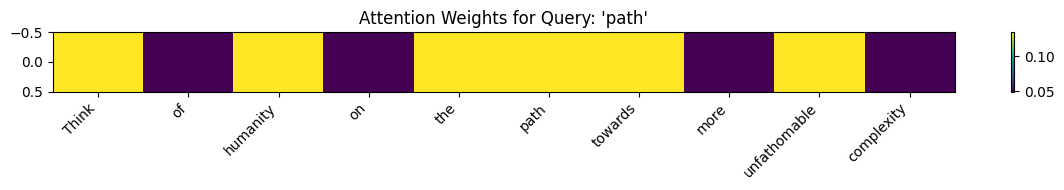

In [16]:
# Visualize attention weights
# Think what words contribute most to the query word's representation
query_word = "path"

plt.figure(figsize=(12, 2))
plt.imshow(F.softmax(query @ key.T, dim=-1).detach(), cmap='viridis', aspect='auto')
plt.title(f"Attention Weights for Query: '{query_word}'")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.colorbar()
plt.tight_layout()
plt.show()

We multiply each value (which in this case is just the position of the word) by its corresponding attention weight and sum the results. In math terms this is matrix multiplication. The result represents a "weighted average" position in the sentence, where positions of words with higher attention weights contribute more to the final sum.

In [18]:
# Show the step-by-step calculation for weighted average
print("\nStep-by-step calculation for a weighted sum:")
for i, (weight, val) in enumerate(zip(attention_weights[0], value)):
    print(f"Word {i}: {weight.item():.2f} * {val.item()} = {weight.item()*val.item():.2f}")


Step-by-step calculation for a weighted sum:
Word 0: 0.13 * 0.0 = 0.00
Word 1: 0.05 * 1.0 = 0.05
Word 2: 0.13 * 2.0 = 0.27
Word 3: 0.05 * 3.0 = 0.15
Word 4: 0.13 * 4.0 = 0.54
Word 5: 0.13 * 5.0 = 0.67
Word 6: 0.13 * 6.0 = 0.80
Word 7: 0.05 * 7.0 = 0.34
Word 8: 0.13 * 8.0 = 1.07
Word 9: 0.05 * 9.0 = 0.44


In [19]:
output = attention_weights @ value
print("Weighted sum also referred to as a context vector:", output)

Weighted sum also referred to as a context vector: tensor([[4.3308]])


In [20]:
mm("""
graph TD
    A[Input Sequence] --> B[Query Q]
    A --> C[Key K]
    A --> D[Value V]
    B --> E[Compute Attention Scores]
    C --> E
    E --> F[Apply Softmax]
    F --> G[Weighted Sum]
    D --> G
    G --> H[Output]
""")

## 1. Dot-Product Attention

In [24]:
def dot_product_attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:

    scores= (query @ key.T)
    attention_weights = torch.softmax(scores, dim=-1)
    return attention_weights @ value  ## weighted sum

In [26]:
try:
    check_implementation(dot_product_attention)
except NotImplementedError as e:
    print(e)

'dot_product_attention' has been implemented. No TODO found.


In [27]:
output = dot_product_attention(query, key, value)
print("Dot-Product Attention Output:", output)

Dot-Product Attention Output: tensor([[4.3308]])


## 2. Scaled Dot-Product Attention

In scaled attention, we introduce a scaling factor of a square root of the dimnesion of key vectors. You might ask why scaling is needed... There are at least 3 reasons:
1. As the dimension of the key vectors increases, the dot products tend to grow larger in magnitude.
2. Large dot products push the softmax function into regions where it has extremely small gradients.
3. This can lead to very peaked (near-one-hot) distributions after softmax, or to vanishing gradients.

In [28]:
def scaled_dot_product_attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:
    d_k = key.size(-1) ## assumes query, key, val have same dim
    scores = (query @ key.T) 
    attention_weights = torch.softmax(scores / d_k**0.5, dim=-1)
    return attention_weights @ value 

In [29]:
try:
    check_implementation(scaled_dot_product_attention)
except NotImplementedError as e:
    print(e)

'scaled_dot_product_attention' has been implemented. No TODO found.


In [30]:
output_scaled = scaled_dot_product_attention(query, key, value)
print("Scaled Dot-Product Attention Output:", output_scaled)

Scaled Dot-Product Attention Output: tensor([[4.3936]])


## 3. Self-Attention

In self-attention, instead of using the input directly as query, key, and value, we create projections of the input. These projections allow the model to transform the input into different representation spaces (and different dimensions). 

Vector projection uses the dot product because the dot product provides a measure of how much one vector aligns with another, which is exactly what projection aims to capture. 

In [31]:
x = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float)

We'd now review the concept of linear transfomation and `nn.Linear`. When we apply the linear layer, it performs the following operation for each sequence element:
output = x @ weight.T + bias

In [32]:
# Let's create a simple example
input_dim = x.shape[1]
out_dim = 3
seq_length = 2
batch_size = 1

# Create an nn.Linear layer
linear_layer = nn.Linear(input_dim, out_dim)

# Print the weight matrix and bias
print("Weight matrix shape:", linear_layer.weight.shape)
print("Weight matrix:")
print(linear_layer.weight.data)
print("\nBias shape:", linear_layer.bias.shape)
print("Bias:")
print(linear_layer.bias.data)

Weight matrix shape: torch.Size([3, 3])
Weight matrix:
tensor([[ 0.1927,  0.1457,  0.4214],
        [-0.2107,  0.0042,  0.2494],
        [-0.4274, -0.5445, -0.1774]])

Bias shape: torch.Size([3])
Bias:
tensor([ 0.5530, -0.1127, -0.0930])


In [33]:
print("\nInput shape:", x.shape)
print("Input:")
print(x)


Input shape: torch.Size([10, 3])
Input:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.],
        [1., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 1.]])


In [34]:
# Apply the linear transformation
output = linear_layer(x)

print("\nOutput shape:", output.shape)
print("Output:")
print(output)


Output shape: torch.Size([10, 3])
Output:
tensor([[ 0.7457, -0.3234, -0.5204],
        [ 0.6987, -0.1085, -0.6376],
        [ 1.1670, -0.0740, -0.6978],
        [ 1.1201,  0.1409, -0.8150],
        [ 1.3128, -0.0698, -1.2424],
        [ 0.7457, -0.3234, -0.5204],
        [ 0.8914, -0.3192, -1.0650],
        [ 0.9743,  0.1367, -0.2704],
        [ 1.1670, -0.0740, -0.6978],
        [ 1.1201,  0.1409, -0.8150]], grad_fn=<AddmmBackward0>)


In [35]:
# Verification with the dot product
manual_output = torch.matmul(x, linear_layer.weight.t()) + linear_layer.bias
print("\nManual calculation output:")
print(manual_output)
print("\nDoes manual calculation match nn.Linear output?", torch.allclose(output, manual_output))


Manual calculation output:
tensor([[ 0.7457, -0.3234, -0.5204],
        [ 0.6987, -0.1085, -0.6376],
        [ 1.1670, -0.0740, -0.6978],
        [ 1.1201,  0.1409, -0.8150],
        [ 1.3128, -0.0698, -1.2424],
        [ 0.7457, -0.3234, -0.5204],
        [ 0.8914, -0.3192, -1.0650],
        [ 0.9743,  0.1367, -0.2704],
        [ 1.1670, -0.0740, -0.6978],
        [ 1.1201,  0.1409, -0.8150]], grad_fn=<AddBackward0>)

Does manual calculation match nn.Linear output? True


The key difference between this and regular scaled dot-product attention is the use of learned projections (Q, K, V) instead of using the input directly. This self-attention mechanism allows each position in the sequence to attend to all positions, including itself.
The `nn.Linear` layers are crucial here:
1. They introduce learnable parameters, allowing the model to adapt how it projects the input for attention computation.
2. They enable the model to transform the input in ways that are most useful for the task at hand, which is learned during training.

In [36]:

class SimpleSelfAttention(nn.Module):
    def __init__(self, input_dim: int, out_dim: int):
        super(SimpleSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim

        # Create linear projections for Q, K, V
        self.q_proj = nn.Linear(input_dim, out_dim)
        self.k_proj = nn.Linear(input_dim, out_dim)
        self.v_proj = nn.Linear(input_dim, out_dim)
        
        self.fc_out = nn.Linear(out_dim, input_dim) # -> (batch_size, seq_length, input_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # TODO: Implement SimpleSelfAttention class forward()
        # Hint: Use self.q_proj, self.k_proj, and self.v_proj to create projections from the input
        # Apply the scaled dot-product attention mechanism using these projections
        # Use self.fc_out for the final projection
        # Return both output and attention weights
        keys = self.q_proj(x)       ## [B, seq_length, out_dim]
        queries = self.k_proj(x)    ## [B, seq_length, out_dim]
        values = self.v_proj(x)     ## [B, seq_length, out_dim]
        
        scores  = torch.matmul(queries, keys.transpose(-2, -1)) ## [B, seq_length, seq_length]
        weights = torch.softmax(scores/keys.shape[-1]**0.5, dim=-1)
        
        return self.fc_out(torch.matmul(weights, values)), weights
        
        

In [37]:
try:
    check_implementation(SimpleSelfAttention)
except NotImplementedError as e:
    print(e)
# even if you correctly implement forward function for this nn.Module you'll still get a warning
# do you know why?
# if not, go forward and check the next class implementation

'forward' in class 'SimpleSelfAttention' contains a TODO placeholder and must be implemented.
'state_dict' in class 'SimpleSelfAttention' contains a TODO placeholder and must be implemented.


In [38]:
self_attention = SimpleSelfAttention(input_dim, out_dim)
output, attention_weights = self_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([10, 3])
Output shape: torch.Size([10, 3])
Attention weights shape: torch.Size([10, 10])


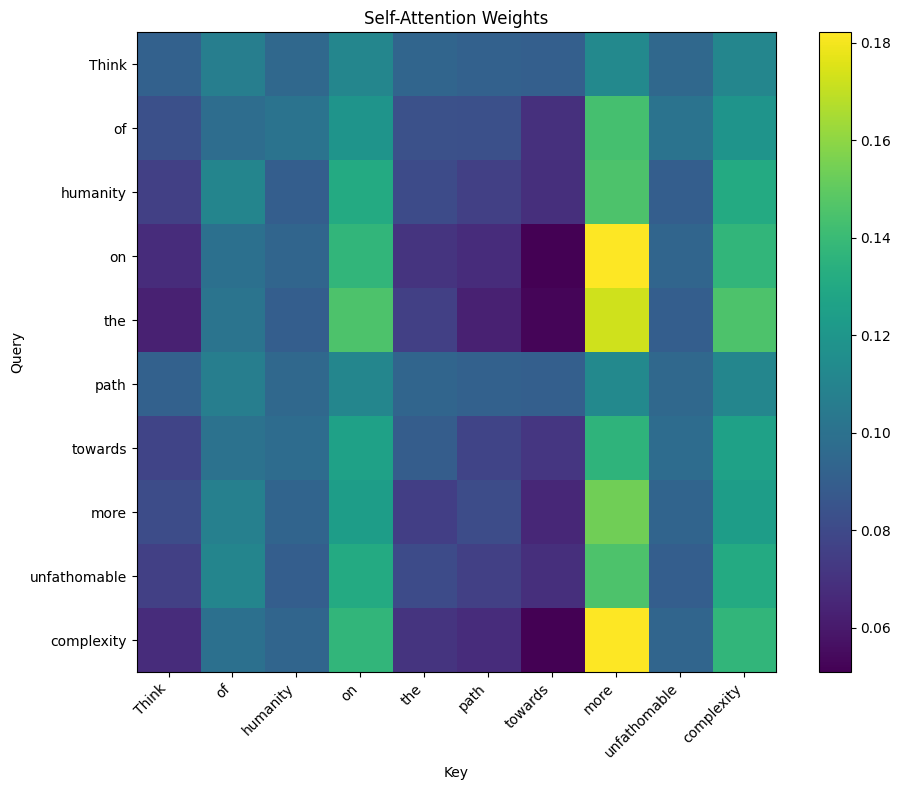

In [39]:
# Visualize attention weights
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights.detach().numpy(), cmap='viridis')  # Convert to numpy if needed
plt.title("Self-Attention Weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Causal Attention with Masking

With GPT models, the autoregressive property is important to maintain. It refers to a characteristic of certain models, where the prediction of the current step or value depends only on the information from the previous steps or values.

Causal attention, also known as masked attention, is a specialized form of self-attention.

It restricts a model to only consider previous and current inputs in a sequence when processing any given token

From the math perspective, `torch.triu` creates an upper triangular matrix from an input tensor with teh main diagonal and above. It's often used to create masks for causal attention in transformer models.

In [40]:
matrix = torch.ones(5, 5)
print("Original matrix:")
print(matrix)

Original matrix:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [41]:
upper_triangular = torch.triu(matrix)
print("\nUpper triangular matrix:")
print(upper_triangular)


Upper triangular matrix:
tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])


In [42]:
# Offset the diagonal
offset_triangular = torch.triu(matrix, diagonal=1)
print("\nUpper triangular matrix with offset 1:")
print(offset_triangular)


Upper triangular matrix with offset 1:
tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])


In [43]:
# Make masked values be ignored also after Softmax
neg_inf = upper_triangular.masked_fill(upper_triangular == 0, float('-inf'))
neg_inf

tensor([[1., 1., 1., 1., 1.],
        [-inf, 1., 1., 1., 1.],
        [-inf, -inf, 1., 1., 1.],
        [-inf, -inf, -inf, 1., 1.],
        [-inf, -inf, -inf, -inf, 1.]])

Any `-inf` value in scores will result in a zero probability after applying the Softmax function, meaning those positions are ignored. This effectively ensures that each token can only attend to itself and the tokens before it in the sequence.

In [44]:
# Creating a boolean mask
mask = torch.triu(matrix, diagonal=1).bool()
print("\nBoolean mask for upper triangular with offset 1:")
print(mask)


Boolean mask for upper triangular with offset 1:
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [45]:
class CausalSelfAttention(nn.Module):
    def __init__(self, input_dim: int, out_dim: int):
        super(CausalSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.q_proj = nn.Linear(input_dim, out_dim)
        self.k_proj = nn.Linear(input_dim, out_dim)
        self.v_proj = nn.Linear(input_dim, out_dim)
        
        self.fc_out = nn.Linear(out_dim, input_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        batch_size, seq_length, _ = x.size()

        # TODO: Implement CausalSelfAttention class forward pass
        # Hint: 1. re-use SimpleSelfAttention
        # 2. create causal mask using torch.triu over x 
        # 3. update mask zero values to -inf before Softmax
        
        keys = self.q_proj(x)       ## [B, seq_length, out_dim]
        queries = self.k_proj(x)    ## [B, seq_length, out_dim]
        values = self.v_proj(x)     ## [B, seq_length, out_dim]
        
        scores  = torch.matmul(queries, keys.transpose(-2, -1)) ## [B, seq_length, seq_length]
        
        ## Applying upper triangular matrix above diagonal
        causal_mask = torch.triu(torch.ones(seq_length, seq_length, device=x.device), diagonal=1).bool()
        ## Set masked pos to -inf before softmax
        scores = scores.masked_fill(causal_mask, float('-inf')) 
        
        weights = torch.softmax(scores/keys.shape[-1]**0.5, dim=-1)
        
        return self.fc_out(torch.matmul(weights, values)), weights
        
    

In [46]:
try:
    check_implementation(CausalSelfAttention)
except NotImplementedError as e:
    print(e)
# you will see here the similar warning as in SimpleSelfAttention
# where is the 'TODO' placeholder then?
# and you can move on once your forward pass is ready

'forward' in class 'CausalSelfAttention' contains a TODO placeholder and must be implemented.
'state_dict' in class 'CausalSelfAttention' contains a TODO placeholder and must be implemented.


In [47]:
x = x.unsqueeze(0)  # Add batch dimension
x.shape

torch.Size([1, 10, 3])

In [48]:
causal_attention = CausalSelfAttention(input_dim, out_dim)
output, attention_weights = causal_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([1, 10, 3])
Output shape: torch.Size([1, 10, 3])
Attention weights shape: torch.Size([1, 10, 10])


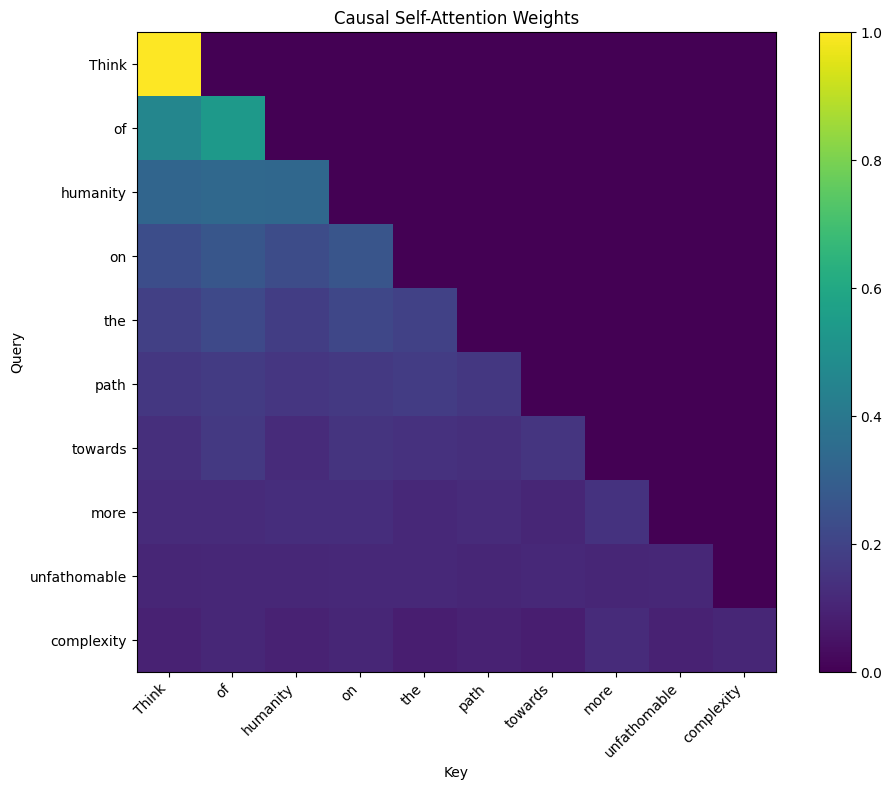

In [49]:
# Visualize attention weights
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')  # Convert to numpy if needed
plt.title("Causal Self-Attention Weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()
plt.tight_layout()
plt.show()

In [50]:
# Print transformed vectors for each word
print("\nTransformed word vectors:")
for i, word in enumerate(words):
    print(f"{word}: {output[0][i].detach().numpy()}")


Transformed word vectors:
Think: [ 0.67880696 -0.10575521  0.09769427]
of: [ 0.5112532  -0.26625273  0.03583891]
humanity: [ 0.6619302  -0.2878243   0.11999277]
on: [ 0.6440644  -0.3854609   0.12724417]
the: [ 0.7238368  -0.41445398  0.14927867]
path: [ 0.72864074 -0.36217105  0.1447958 ]
towards: [ 0.7290394  -0.35329175  0.12813458]
more: [ 0.70138496 -0.36527258  0.14423251]
unfathomable: [ 0.7383376  -0.36344075  0.15754691]
complexity: [ 0.7067404  -0.39740533  0.15649852]


#### Question to you

We now see how an autoregressive setting works with triangular mask. And that's the approach in decoder attention block. Thinking about encoder block and its setting of all tokens communicating with each other, what should we update in the current implementation of decoder to allow for this communication as in encoders? 

In encoder, we remove the causal masking to allow all tokens to communicate with each other.

## 5. Multi-Head Attention

In [51]:
batch_size, seq_length, d_model = x.shape
num_heads = 3  # We'll use 3 heads since d_model is 3
head_dim = d_model // num_heads  # This will be 1 in this case

print(f"Input shape: {x.shape}")

Input shape: torch.Size([1, 10, 3])


In [52]:
# Linear projections
W_q = nn.Linear(d_model, d_model)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)

# Apply projections
Q = W_q(x)
K = W_k(x)
V = W_v(x)

print(f"\nShape after linear projection:")
print(f"Q shape: {Q.shape}")


Shape after linear projection:
Q shape: torch.Size([1, 10, 3])


#### Question to you

It won't be in our scope but have you thought of a "proper" weight initialization? If not but you want to think of it, check `xavier_uniform_`.

In [53]:
# Transpose to get dimensions [batch_size, num_heads, seq_len, head_dim]
Q = Q.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)

print(f"\nShape after reshaping for multi-head:")
print(f"Q shape: {Q.shape}")


Shape after reshaping for multi-head:
Q shape: torch.Size([1, 3, 10, 1])


In [54]:
# Perform attention for each head
scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)
attention_weights = torch.softmax(scores, dim=-1)
head_outputs = torch.matmul(attention_weights, V)

print(f"\nShape of each head's output:")
print(f"head_outputs shape: {head_outputs.shape}")


Shape of each head's output:
head_outputs shape: torch.Size([1, 3, 10, 1])


In [55]:
# Transpose and concatenate heads [batch_size, seq_len, d_model]
concat_heads = head_outputs.transpose(1, 2).contiguous().view(batch_size, seq_length, d_model)

print(f"\nShape after concatenating heads:")
print(f"concat_heads shape: {concat_heads.shape}")


Shape after concatenating heads:
concat_heads shape: torch.Size([1, 10, 3])


In [56]:
# Project final output
W_o = nn.Linear(d_model, d_model)
output = W_o(concat_heads)

print(f"\nFinal output shape:")
print(f"output shape: {output.shape}")


Final output shape:
output shape: torch.Size([1, 10, 3])


In [57]:
# Print attention weights for the first head
print(f"\nAttention weights for the first head:")
print(attention_weights[0, 0])


Attention weights for the first head:
tensor([[0.1007, 0.1007, 0.0995, 0.0995, 0.0996, 0.1007, 0.1009, 0.0994, 0.0995,
         0.0995],
        [0.0935, 0.0940, 0.1041, 0.1047, 0.1031, 0.0935, 0.0926, 0.1057, 0.1041,
         0.1047],
        [0.0965, 0.0968, 0.1022, 0.1025, 0.1017, 0.0965, 0.0960, 0.1031, 0.1022,
         0.1025],
        [0.0894, 0.0901, 0.1067, 0.1077, 0.1050, 0.0894, 0.0879, 0.1095, 0.1067,
         0.1077],
        [0.0924, 0.0930, 0.1048, 0.1055, 0.1036, 0.0924, 0.0913, 0.1067, 0.1048,
         0.1055],
        [0.1007, 0.1007, 0.0995, 0.0995, 0.0996, 0.1007, 0.1009, 0.0994, 0.0995,
         0.0995],
        [0.0966, 0.0968, 0.1022, 0.1025, 0.1016, 0.0966, 0.0961, 0.1030, 0.1022,
         0.1025],
        [0.0934, 0.0939, 0.1042, 0.1047, 0.1031, 0.0934, 0.0925, 0.1058, 0.1042,
         0.1047],
        [0.0965, 0.0968, 0.1022, 0.1025, 0.1017, 0.0965, 0.0960, 0.1031, 0.1022,
         0.1025],
        [0.0894, 0.0901, 0.1067, 0.1077, 0.1050, 0.0894, 0.0879, 0.109

In [91]:
# %%writefile src/multiattention.py
import torch
import torch.nn as nn
import math
from typing import Tuple, List


class CausalSelfAttention(nn.Module):
    def __init__(self, input_dim: int, out_dim: int):
        super(CausalSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.q_proj = nn.Linear(input_dim, out_dim)
        self.k_proj = nn.Linear(input_dim, out_dim)
        self.v_proj = nn.Linear(input_dim, out_dim)
        
        self.fc_out = nn.Linear(out_dim, input_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        batch_size, seq_length, _ = x.size()

        # TODO: Implement CausalSelfAttention class forward pass
        # Hint: 1. re-use SimpleSelfAttention
        # 2. create causal mask using torch.triu over x 
        # 3. update mask zero values to -inf before Softmax
        
        keys = self.q_proj(x)       ## [B, seq_length, out_dim]
        queries = self.k_proj(x)    ## [B, seq_length, out_dim]
        values = self.v_proj(x)     ## [B, seq_length, out_dim]
        
        scores  = torch.matmul(queries, keys.transpose(-2, -1)) ## [B, seq_length, seq_length]
        
        ## Applying upper triangular matrix above diagonal
        causal_mask = torch.triu(torch.ones(seq_length, seq_length, device=x.device), diagonal=1).bool()
        ## Set masked pos to -inf before softmax
        scores = scores.masked_fill(causal_mask, float('-inf')) 
        
        weights = torch.softmax(scores/keys.shape[-1]**0.5, dim=-1)
        
        return self.fc_out(torch.matmul(weights, values)), weights
        
    
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.d_model = d_model # the output dimensionality
        self.num_heads = num_heads # the number of attention heads
        self.head_dim = d_model // num_heads # dimensionality of each head output

        # Making sure that each head will process a portion of the output
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"

        # Initialize weights for Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        # Scaling factor
        #self.scale = self.head_dim ** -0.5
        self.scale = 1 / math.sqrt(self.head_dim)

    def forward(self, x: torch.Tensor,
            mask: torch.Tensor = None
        ) -> Tuple[torch.Tensor, torch.Tensor]:

        b, n_tokens, d_in = x.shape

        # TODO: Implement a multi-head attention class forward pass
        
        # Hint: 1. Apply linear projections to self.W_q, self.W_k and self.W_v
        # 2. Use previously created CausalSelfAttention 
        # 3. Update attention scores using self.scale instead of math.sqrt(self.out_dim)
        # 4. Concatenate heads with final output projection
        
        Q = self.W_q(x)  
        K = self.W_k(x)
        V = self.W_v(x)
        
        ## Reshape QKV for mha (split across heads)
        ## Unroll last dim: [ b, n_tokens, d_out ] -> [ b, n_tokens, n_heads, head_dim ] 
        ## Transpose [ b, n_tokens, n_heads, head_dim ] -> [ b, n_heads, n_tokens, head_dim ] 
        Q = Q.view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        
        ## Scaled dot-product attention
        scores = Q @ K.transpose(2, 3) # Dot product for each head
        print(scores.shape)
        
        if mask is None:
            ## Causal mask to prevent attending future tokens
            mask = torch.triu(torch.ones(n_tokens, n_tokens, device=x.device), diagonal=1).bool()

        ## Apply mask by setting future attention scores to future tokens
        scores = scores.masked_fill(mask, float('-inf'))
        
        attn_weights = torch.softmax(scores * self.scale, dim=-1)  ## [ b, n_heads, n_tokens, n_tokens ] 
        attn_output = torch.matmul(attn_weights, V)  ## [ b, n_heads, n_tokens, head_dim ] 
        
        ## Concat heads back together
        ## Combine heads, where self.d_out = self.num_heads * self.head_dim
        attn_output = attn_output.transpose(1, 2).contiguous().view(b, n_tokens, self.d_model) 
        output = self.W_o(attn_output) ## [b, n_tokens, d_model]
        return output, attn_weights
        

mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = mha(x)

torch.Size([1, 3, 10, 10])


In [ ]:
from src.multiattention import MultiHeadAttention

try:
    check_implementation(MultiHeadAttention)
except NotImplementedError as e:
    print(e)
# you can move on once your forward pass is ready

In [92]:
mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = mha(x)

torch.Size([1, 3, 10, 10])


In [93]:
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([1, 10, 3])
Output shape: torch.Size([1, 10, 3])
Attention weights shape: torch.Size([1, 3, 10, 10])


## 5. Attention Mechanism Visualization

In [94]:
def visualize_attention(attention_weights: torch.Tensor, words: List[str] = None, title: str = "Attention Weights") -> None:
    """
    Visualize attention weights as a heatmap.
    
    Parameters:
    - attention_weights: torch.Tensor or numpy array of shape (seq_length, seq_length)
    - words: list of words corresponding to the sequence (optional)
    - title: title for the plot
    """
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(10, 8))   
    sns.heatmap(attention_weights, 
                annot=True, 
                cmap='viridis', 
                ax=ax, 
                cbar=True,
                fmt='.2f')
    
    ax.set_title(title)
    if words:
        ax.set_xticks(range(len(words)))
        ax.set_yticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.set_yticklabels(words, rotation=0)
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
    else:
        ax.set_xlabel('Sequence Position (Key)')
        ax.set_ylabel('Sequence Position (Query)')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

torch.Size([1, 3, 10, 10])


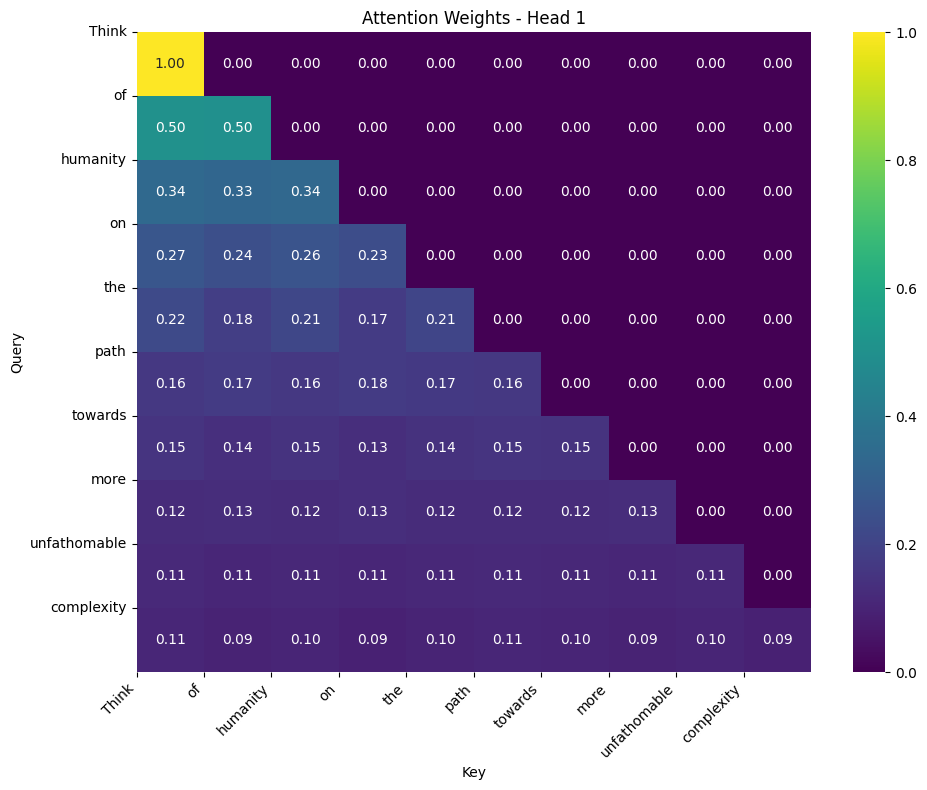

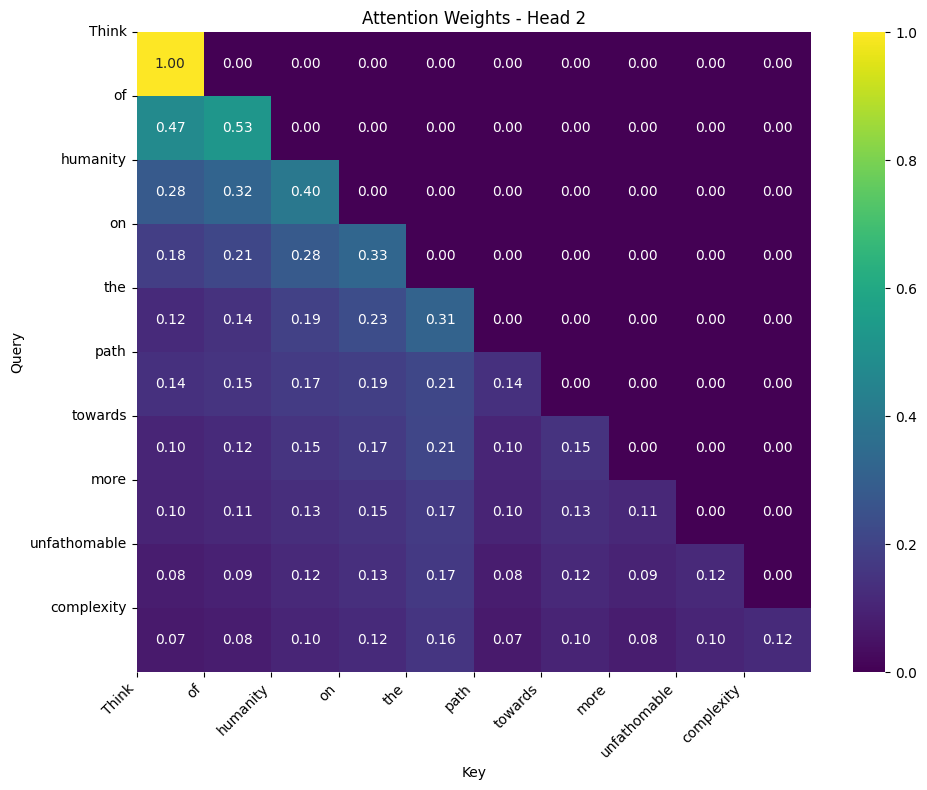

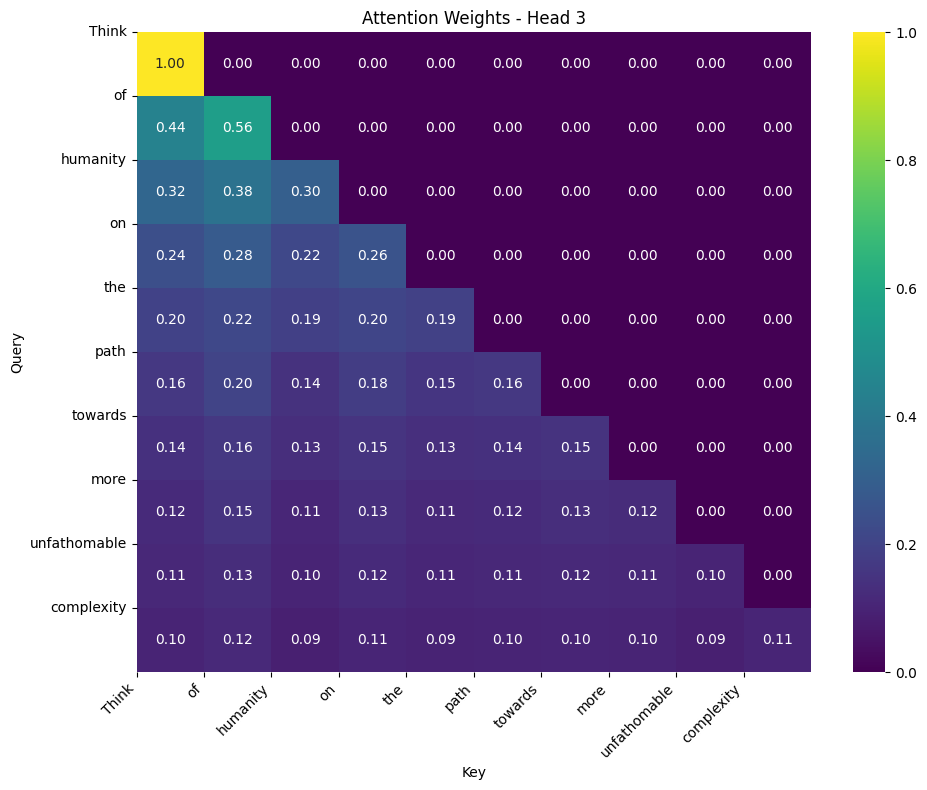

In [96]:
# TODO: Experiment with the input
# Not checking this but highly recommending

sentence = "Think of humanity on the path towards more unfathomable complexity"
words = sentence.split()

# Create input tensor
word_to_vec = {
    "Think": [1, 0, 0], 
    "of": [0, 1, 0], 
    "humanity": [1, 0, 1],
    "on": [0, 1, 1], 
    "the": [1, 1, 1], 
    "path": [1, 0, 0],
    "towards": [1, 1, 0], 
    "more": [0, 0, 1], 
    "unfathomable": [1, 0, 1],
    "complexity": [0, 1, 1]
}

x = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float).unsqueeze(0)

d_model = 3  # Dimension of our word vectors
num_heads = 3  # We'll use 3 heads for simplicity, but you can increase this
mha = MultiHeadAttention(d_model, num_heads)

# Get attention weights
_, attention_weights = mha(x)

# Visualize
for i in range(num_heads):
    visualize_attention(attention_weights[0, i], words, f"Attention Weights - Head {i+1}")

#### Congratulations! You've implemented various attention mechanisms. These will be crucial components in building your LLM in the coming weeks.